In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
import warnings
warnings.simplefilter("ignore")
np.random.seed(42)
print("Tensorflow Version is :",tf.__version__)

Tensorflow Version is : 2.10.1


In [58]:
training_path = './dataset/train/'
#training_path = './dataset/separate_train/'

In [59]:
train_images = pd.read_csv(training_path+"/images.csv",header=None)
#train_images = pd.read_csv(training_path+"/images-1.csv",header=None)
train_labels = pd.read_csv("./dataset/train/labels.csv",header=None)
val_images = pd.read_csv("./dataset/validation/images.csv",header=None)
val_labels = pd.read_csv("./dataset/validation/labels.csv",header=None)

# Data Shaping

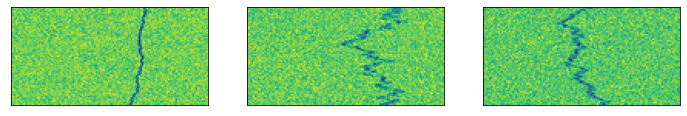

In [60]:
# according to source data 
size_image = (64,128)

# reshape the data into a shape that fits with CNN
x_train = train_images.values.reshape(len(train_images), size_image[0], size_image[1], 1)
x_val = val_images.values.reshape(len(val_images), size_image[0], size_image[1], 1)

y_train = train_labels.values
y_val = val_labels.values

# examples
plt.figure(0, figsize=(12,12))
for i in range(1,4):
    plt.subplot(1,3,i)
    img = x_train[i]
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)

# Image Generators for Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

datagen_train = ImageDataGenerator(horizontal_flip=True)
datagen_train.fit(x_train)

datagen_val = ImageDataGenerator(horizontal_flip=True)
datagen_val.fit(x_val)

# Sizes after different operations

In [47]:
def conv2d_size(input_size, kernel_size, stride):
    """ using padding='valid'
    """
    return np.floor((input_size - kernel_size + stride)/stride)

input_size = np.array([64,128])
out_first_conv = conv2d_size(input_size, 5, 1)
out_pooling1 = out_first_conv/2

out_second_conv = conv2d_size(out_pooling1, 5, 1)
out_pooling2 = out_second_conv/2

print("Size in theory")
print("First Conv Layers")
print(f"output first conv2D layer: {out_first_conv}")
print(f"output first pooling layer: {out_pooling1}")

print("Second Conv Layers")
print(f"output second conv2D layer: {out_second_conv}")
print(f"output second pooling layer: {out_pooling2}")

Size in theory
First Conv Layers
output first conv2D layer: [ 60. 124.]
output first pooling layer: [30. 62.]
Second Conv Layers
output second conv2D layer: [26. 58.]
output second pooling layer: [13. 29.]


In [29]:
import tensorflow as tf
import tensorflow.keras.layers as layers

In [48]:
conv_layer = layers.Conv2D(
    filters=32, kernel_size=5, padding="valid")

max_pool2x2 = layers.MaxPool2D(pool_size=2)

conv_layer2 = layers.Conv2D(
    filters=64, kernel_size=5, padding="valid")

# First Big Layer
hidden_output = conv_layer(x_train)
hidden_output = max_pool2x2(hidden_output)
# Second Big Layer
hidden_output = conv_layer2(hidden_output)
hidden_output = max_pool2x2(hidden_output)
print("Actual size")
hidden_output.shape

Actual size


TensorShape([9, 13, 29, 64])

# Model Section

In [6]:
import tensorflow as tf
import tensorflow.keras.layers as layers

from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

## Classical Model 1

In [79]:
model = tf.keras.Sequential([
    layers.Conv2D(
        filters=32, kernel_size=5, padding="valid", input_shape=(64, 128,1)), 
    layers.BatchNormalization(), 
    layers.Activation("relu"), layers.MaxPool2D(pool_size=2),
    layers.Dropout(0.25),
    
    layers.Conv2D(
        filters=64, kernel_size=5, padding="valid"), 
    layers.BatchNormalization(), 
    layers.Activation("relu"), layers.MaxPool2D(pool_size=2),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(1024, kernel_initializer="he_normal"), 
    layers.BatchNormalization(), layers.Activation("relu"),
    layers.Dropout(0.4),

    layers.Dense(4, activation="softmax", kernel_initializer="he_normal")
    ])

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])


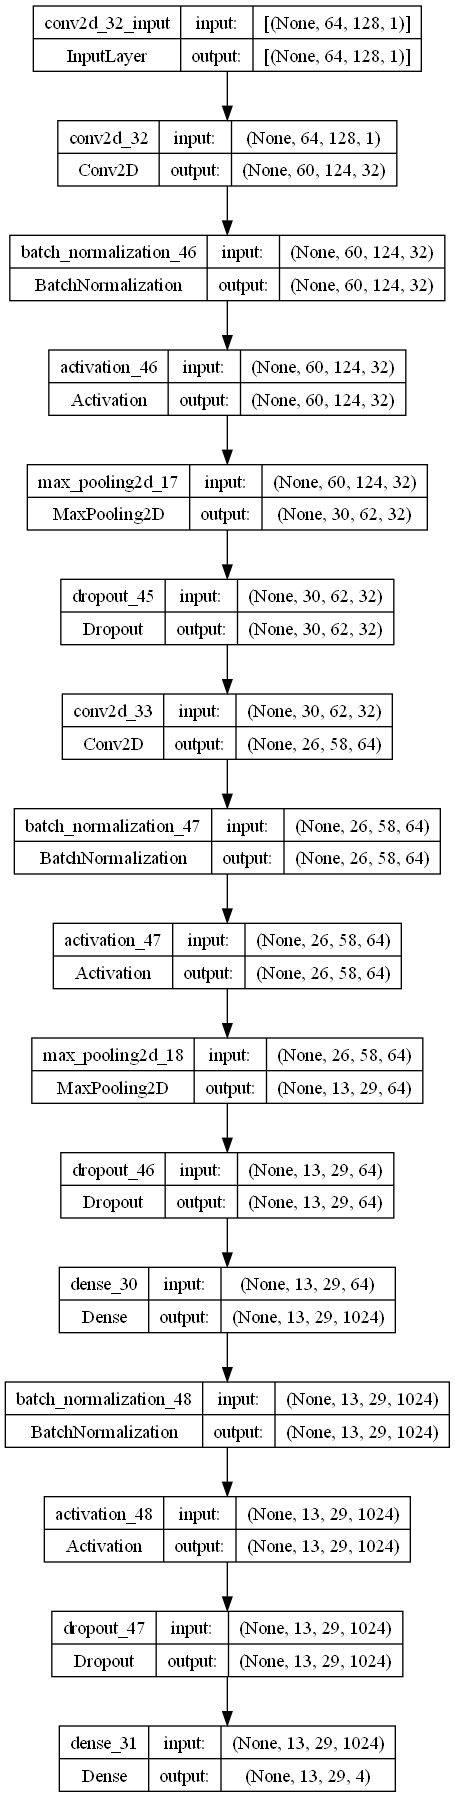

In [64]:
plot_model(model, to_file='cnn.png', 
    show_shapes=True, show_layer_names=True, expand_nested=True)

In [73]:

model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 60, 124, 32)       832       
                                                                 
 batch_normalization_49 (Bat  (None, 60, 124, 32)      128       
 chNormalization)                                                
                                                                 
 activation_49 (Activation)  (None, 60, 124, 32)       0         
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 30, 62, 32)       0         
 g2D)                                                            
                                                                 
 dropout_48 (Dropout)        (None, 30, 62, 32)        0         
                                                                 
 conv2d_35 (Conv2D)          (None, 26, 58, 64)      

In [74]:
from livelossplot.tf_keras import PlotLossesCallback
from livelossplot import PlotLossesKeras

In [75]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(3200, 64, 128, 1)
(3200, 4)
(800, 64, 128, 1)
(800, 4)


In [80]:
plotlosses = PlotLossesKeras()

#checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_loss',
#                             save_weights_only=True, mode='min', verbose=0)
# PlotLossesCallback() is not supported by Tensorflow 2.2.
#callbacks = [PlotLossesKeras(), checkpoint]#, reduce_lr] 
batch_size = 2

history = model.fit(
    x=x_train,
    y=y_train,
    steps_per_epoch=len(x_train)//batch_size,
    validation_data = (x_val, y_val),
    validation_steps = len(x_val)//batch_size,
    epochs=12,
    callbacks=[plotlosses]
)


Epoch 1/12
  43/1600 [..............................] - ETA: 10:56 - loss: 2.2326 - accuracy: 0.2791

KeyboardInterrupt: 